# In this note book I'm going to build a CNN model from scratch and then I'll use some pre-trained CNN model. 

### we can either use the pretrained model as is or use transfer learning to customize this model to what we want to do.

### Also the dataset which I use here is Galazy-zoo-classification which has 5 different types of galaxy shapes. So let's begin.



# Step 1 | Importing and installing libraries

In [1]:
!pip install split-folders

In [2]:
!pip install pathlib

In [4]:
# warnings
import warnings
warnings.filterwarnings('ignore')

# framework
import tensorflow as tf
from tensorflow import keras

# preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
import pathlib

# visualizations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pre-trained models and layers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D,Rescaling, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers import Adam

# Step 2 | Preprocessing and Visualization

In [5]:
path = "/kaggle/input/galaxy-zoo-classification/Train_images/Train_images"
image_path = pathlib.Path(path)

In [6]:
# splitting train, test, val using splitfolders
splitfolders.ratio(input=image_path, output="Galaxy_dataset", seed=42, ratio=(0.7,0.15,0.15))

Copying files: 28793 files [01:54, 252.38 files/s]


In [8]:
# choosing a batch size
batch_size=8

In [9]:
# converting images to tensors

training_data = keras.utils.image_dataset_from_directory(directory="Galaxy_dataset/train",
                                                         labels="inferred",
                                                         label_mode="categorical",
                                                         batch_size=batch_size,
                                                         image_size=(256,256))

validation_data = keras.utils.image_dataset_from_directory(directory="Galaxy_dataset/val",
                                                          labels="inferred",
                                                          batch_size=batch_size,
                                                          label_mode="categorical",
                                                          image_size=(256,256))

test_data = keras.utils.image_dataset_from_directory(directory="Galaxy_dataset/test",
                                                         labels="inferred",
                                                         label_mode="categorical",
                                                         batch_size=batch_size,
                                                         image_size=(256,56))

Found 20154 files belonging to 5 classes.
Found 4316 files belonging to 5 classes.
Found 4323 files belonging to 5 classes.


**The code above returns a tf.data.Dataset object.**

In [10]:
# checking class names
print(training_data.class_names)
print(test_data.class_names)
print(validation_data.class_names)

['Cigar-shaped smooth', 'In between smooth', 'completely round smooth', 'edge-on', 'spiral']
['Cigar-shaped smooth', 'In between smooth', 'completely round smooth', 'edge-on', 'spiral']
['Cigar-shaped smooth', 'In between smooth', 'completely round smooth', 'edge-on', 'spiral']


In [11]:
# checking the shape of images
for image in training_data.take(1):
    print(image[0].shape)

(8, 256, 256, 3)


In [12]:
class_names = ['Cigar-shaped smooth', 'In between smooth', 
               'completely round smooth', 'edge-on', 'spiral']

In [14]:
def pictures(dataset): 
    plt.figure(figsize=(10, 5))
    for images, labels in dataset.take(1):
        for i in range(8):  
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint16"))
            plt.title(class_names[tf.argmax(labels[i], axis = 0).numpy()])
            plt.axis("off")
    plt.show()

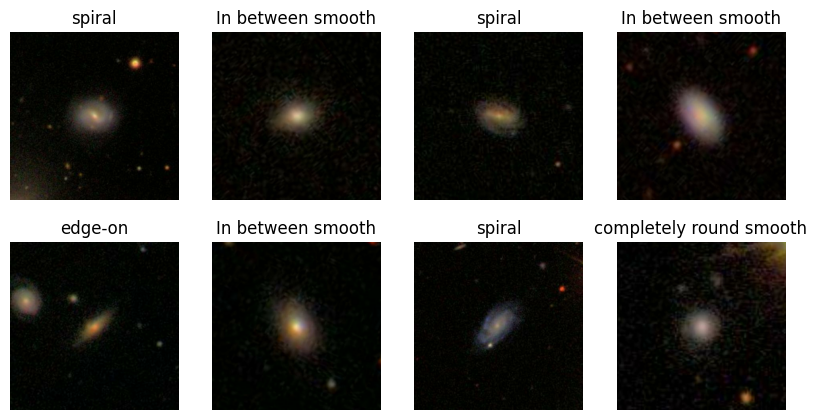

In [18]:
pictures(training_data)

## Galaxy Shapes in Astronomy
### In astronomy, galaxies come in various shapes and classifications based on their visual appearance. Here are some common galaxy shapes and descriptions:

### 1. Cigar-Shaped Smooth:
#### Description: Cigar-shaped smooth galaxies, also known as elliptical galaxies, appear elongated and have a smooth, featureless appearance. They lack distinct spiral arms and are characterized by their ellipsoidal or spherical shape.
#### Properties: Elliptical galaxies contain older stars and exhibit little ongoing star formation. They are often found in galaxy clusters and are thought to result from galaxy mergers or interactions.

### 2. In Between Smooth:
#### Description: In between smooth galaxies, also known as lenticular galaxies (S0 galaxies), exhibit characteristics of both elliptical and spiral galaxies. They have a disk-like structure similar to spirals but lack prominent spiral arms.
#### Properties: Lenticular galaxies contain older stars like ellipticals but also have some dust and gas like spirals. They are often found in galaxy groups and are believed to represent a transitional stage between ellipticals and spirals.

### 3. Completely Round Smooth:
#### Description: Completely round smooth galaxies, also classified as spherical galaxies, have a perfectly round shape with no discernible elongation. They appear symmetrical and lack the flattened disk structure of spirals or lenticulars.
#### Properties: Spherical galaxies are relatively rare and are composed mainly of older stars. They are often found in the central regions of galaxy clusters, where interactions and mergers have shaped their round morphology.

### 4. Edge-On:
#### Description: Edge-on galaxies, whether spiral or lenticular, are oriented in such a way that their disk appears edge-on when viewed from Earth. This orientation gives them a thin, elongated appearance with a distinct edge.
#### Properties: Edge-on galaxies provide valuable insights into the structure and dynamics of galactic disks, including the presence of dust lanes, stellar populations, and potential bars or spiral arms along the disk.

### 5. Spiral:
#### Description: Spiral galaxies are characterized by their prominent spiral arms that wrap around a central bulge. They have a flattened disk structure with ongoing star formation, young stars, gas, and dust associated with the spiral arms.
#### Properties: Spiral galaxies, such as the Milky Way, exhibit a wide range of shapes, from tightly-wound spirals to loose, flocculent spirals. They are dynamic systems with active star formation regions and are crucial for understanding galactic evolution.

### These galaxy shapes provide astronomers with key insights into the formation, evolution, and dynamics of galaxies in the universe. By studying the different types of galaxies and their properties, scientists can unravel the mysteries of the cosmos and our place within it.

# Step 3 | CNN Model

### I build a CNN model from scratch here and use some regularization so tthat the model performs better. After that I train the CNN model on the training dataset and use validation dataset to check how well the performance of the model is and at the end I use some plots to show the resualts better.

In [19]:
CNN_one = keras.models.Sequential()


# first conv and max layer + dropout layer to prevent overfitting
CNN_one.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=[256,256,3]))
CNN_one.add(MaxPool2D(pool_size=2, strides=2))
CNN_one.add(BatchNormalization())
CNN_one.add(Dropout(0.5))

# second conv and max layer + dropout layer
CNN_one.add(Conv2D(filters=65, kernel_size=3, activation="relu", kernel_regularizer="l2"))
CNN_one.add(MaxPool2D(pool_size=2, strides=2))
CNN_one.add(BatchNormalization())
CNN_one.add(Dropout(0.2))

# third conv and max layer + dropout layer
CNN_one.add(Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer="l2"))
CNN_one.add(MaxPool2D(pool_size=2, strides=2))
CNN_one.add(BatchNormalization())
CNN_one.add(Dropout(0.2))

# forth conv and max layer + dropout layer
CNN_one.add(Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer="l2"))
CNN_one.add(MaxPool2D(pool_size=2, strides=2))
CNN_one.add(BatchNormalization())
CNN_one.add(Dropout(0.2))

# flattening and dense layers
CNN_one.add(Flatten())
CNN_one.add(Dense(units=512, activation="relu"))
CNN_one.add(Dense(units=5, activation="softmax"))

CNN_one.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 65)   │        18,785 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 65)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 65)     │           260 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 65)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        75,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,084,970 (99.51 MB)

 Trainable params: 26,084,008 (99.50 MB)

 Non-trainable params: 962 (3.76 KB)

In [ ]:
# Training the model
CNN_one.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history1 = CNN_one.fit(x=training_data, validation_data = validation_data, epochs=20)

Epoch 1/20


2024-07-13 10:50:08.533119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129032: 6.56968, expected 5.72998
2024-07-13 10:50:08.533186: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129051: 7.10358, expected 6.26388
2024-07-13 10:50:08.533196: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129052: 6.99086, expected 6.15116
2024-07-13 10:50:08.533205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129062: 7.37213, expected 6.53244
2024-07-13 10:50:08.533213: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129063: 6.0521, expected 5.2124
2024-07-13 10:50:08.533222: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129064: 7.1427, expected 6.30301
2024-07-13 10:50:08.533232: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129072: 7.38607, expected 6.54637
2024-07-13 10:50:08.533

   7/2520 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.2344 - loss: 17.5186      

I0000 00:00:1720867816.767587     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720867816.792655     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2517/2520 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4472 - loss: 4.2939

2024-07-13 10:51:04.448971: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 5.17171, expected 4.3613
2024-07-13 10:51:04.449056: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.10962, expected 5.29921
2024-07-13 10:51:04.449066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.32575, expected 5.51534
2024-07-13 10:51:04.449075: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.90323, expected 6.09282
2024-07-13 10:51:04.449083: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.86856, expected 6.05815
2024-07-13 10:51:04.449110: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.58906, expected 5.77865
2024-07-13 10:51:04.449119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.0516, expected 5.24119
2024-07-13 10:51:04.449128: E external/local_xla/xla/serv

2520/2520 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4473 - loss: 4.2919

W0000 00:00:1720867872.143524     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-13 10:51:15.426578: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129063: 5.35229, expected 4.67255
2024-07-13 10:51:15.426644: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129317: 4.6381, expected 3.95836
2024-07-13 10:51:15.426655: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129442: 5.36458, expected 4.68484
2024-07-13 10:51:15.426664: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129443: 5.7503, expected 5.07056
2024-07-13 10:51:15.426672: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129464: 5.45647, expected 4.77673
2024-07-13 10:51:15.426681: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129486: 5.67042, expected 4.99069
2024-07-13 10:51:15.426689: E externa

2520/2520 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.4473 - loss: 4.2912 - val_accuracy: 0.3570 - val_loss: 3.1479
Epoch 2/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - accuracy: 0.5895 - loss: 1.3037 - val_accuracy: 0.5273 - val_loss: 1.7614
Epoch 3/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.6141 - loss: 1.3309 - val_accuracy: 0.6362 - val_loss: 1.2714
Epoch 4/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.6307 - loss: 1.2385 - val_accuracy: 0.4270 - val_loss: 1.8429
Epoch 5/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.6458 - loss: 1.1868 - val_accuracy: 0.2725 - val_loss: 932.4439
Epoch 6/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.6508 - loss: 1.3536 - val_accuracy: 0.2711 - val_loss: 816.4922
Epoch 7/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.6512 - loss: 1.2116 - val_accuracy: 0.6253 - val_loss: 1.2132
Epoch 8/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.6678 - loss: 

### The first CNN model with custom structure gave us 66.1% accuracy on validation dataset but overall it is not working very well on this dataset. Although it only trained for 20 epochs.

# Checking the loss and accuracy

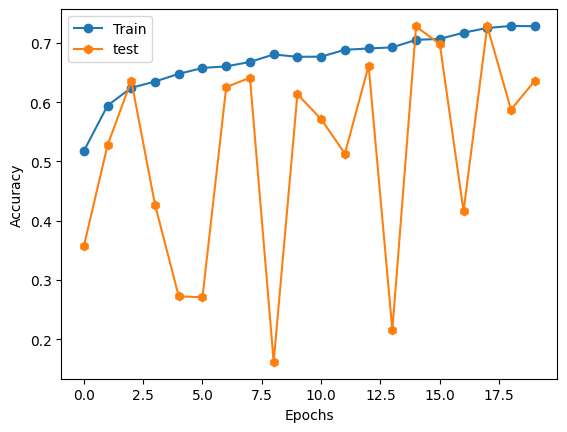

In [21]:
line1 = plt.plot(CNN_one.history.history["accuracy"], marker="o")
line2 = plt.plot(CNN_one.history.history["val_accuracy"], marker="h")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "test"])
plt.show()

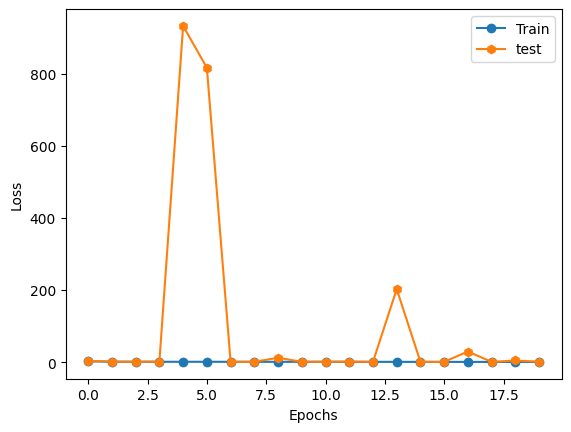

In [22]:
line1 = plt.plot(CNN_one.history.history["loss"], marker="o")
line2 = plt.plot(CNN_one.history.history["val_loss"], marker="h")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "test"])
plt.show()

In [23]:
result_df = pd.DataFrame(history1.history)
result_df

,accuracy,loss,val_accuracy,val_loss
0,0.517515,2.546112,0.357044,3.147882
1,0.594175,1.363131,0.527340,1.761423
2,0.624194,1.266231,0.636237,1.271355
3,0.634713,1.231442,0.427016,1.842887
4,0.647713,1.186838,0.272475,932.443909
5,0.657587,1.198617,0.271084,816.492249
6,0.660316,1.148632,0.625348,1.213230
7,0.667709,1.135710,0.641103,1.222930
8,0.680411,1.136759,0.161956,12.310123
9,0.676392,1.116184,0.613299,1.178233


# Svaing the model

In [24]:
# choosing the best model
best_model = CNN_one

# saving the best model
best_model.save("convnet_from_scratch.h5")

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.h5")
test_loss, test_acc = test_model.evaluate(Flatten(test_data), verbose=2) 
print(f'\nTest accuracy:{test_acc} (test_loss: {test_loss})')

# Step 4 | Using a Pre-trained model

### Feature extraction
In this step, you will freeze the convolutional base created from the previous step and use it as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.


# Step 4.1 | Feature extraction with a pretrained model (VGG16 model)

### In feature extraction, we will use the convolutional and pooling layers from a pretrained model,   and chain the conv layers with a new dense classifier, and train it end to end on the inputs.

 #### I will use keras.applications to access VGG16 pre-trained model. There are also many other image-classification models.

#### We should freeze the convolutional base which means preventing their weights from being updated during training.

In [26]:
vgg16 = keras.applications.vgg16.VGG16(weights = "imagenet", input_shape=(256,256,3), include_top=False)
vgg16.trainable = False   # Freezing convolutional layers
vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Explanation : 
#### -weights specifies the weight checkpoint from which to initialize the model.
#### -include_top refers to including (or not) the densely connected classifier on top of the network so it should be False. 
#### -input_shape is the shape of the image tensors that we’ll feed to the network.
#### -The final feature map has shape (5, 5, 512). That’s the feature map on top of which we’ll stick a densely connected classifier.

In [27]:
inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.vgg16.preprocess_input(inputs) 
x = vgg16(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
vgg16_model2 = keras.Model(inputs, outputs)

In [28]:
vgg16_model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
history2 = vgg16_model2.fit(training_data,epochs=20, validation_data=validation_data)

Epoch 1/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.5745 - loss: 1483174.0000 - val_accuracy: 0.6226 - val_loss: 1057862.6250
Epoch 2/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.5782 - loss: 1607171.3750 - val_accuracy: 0.6175 - val_loss: 1130477.7500
Epoch 3/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 34ms/step - accuracy: 0.5794 - loss: 1609768.1250 - val_accuracy: 0.6443 - val_loss: 752383.5000
Epoch 4/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.5754 - loss: 1666348.5000 - val_accuracy: 0.6022 - val_loss: 1606422.0000
Epoch 5/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.5919 - loss: 1602227.1250 - val_accuracy: 0.6110 - val_loss: 1200433.1250
Epoch 6/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.5964 - loss: 1596002.3750 - val_accuracy: 0.6158 - val_loss: 1665164.7500
Epoch 9/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.6032 - loss: 1663866.2500 - val_accuracy: 0.6198 - val_loss: 145522

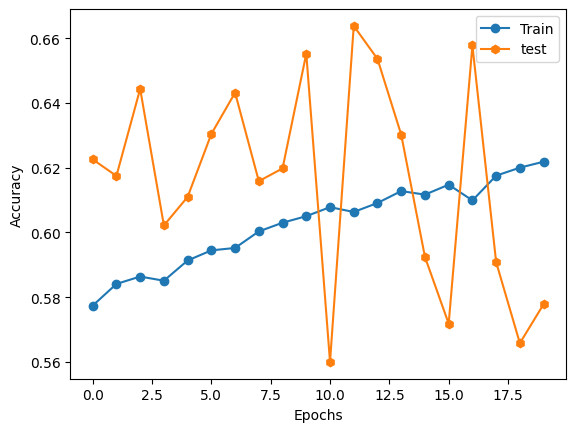

In [34]:
line1 = plt.plot(vgg16_model2.history.history["accuracy"], marker="o")
line2 = plt.plot(vgg16_model2.history.history["val_accuracy"], marker="h")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "test"])
plt.show()

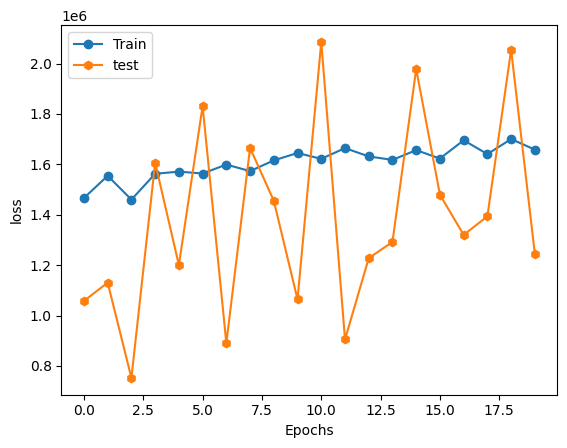

In [35]:
line1 = plt.plot(vgg16_model2.history.history["loss"], marker="o")
line2 = plt.plot(vgg16_model2.history.history["val_loss"], marker="h")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["Train", "test"])
plt.show()

#### This is the accuracy of 20 epochs.

# Step 4.2 | Fine tuning with a pretrained model (VGG16 model)

### In the feature extraction the weights of the pre-trained network were not updated during training. In fine-tuning we train or fine-tune the weights of the top layers of the pre-trained model and then train the classifier we added befor, but we don't need to train all the layers of a pre-trained model. Just a small number of layers will do.
#### The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

#### Also, you should try to fine-tune a small number of top layers rather than the whole VGG16 model model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [37]:
vgg16.trainable = True   # unfreezing convolutional layers

In [38]:
print("Number of layers in the base model: ", len(vgg16.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [39]:
vgg16_model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [41]:
history3 = vgg16_model2.fit(training_data,epochs=20, validation_data=validation_data)

Epoch 1/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 93s 35ms/step - accuracy: 0.6237 - loss: 1717704.2500 - val_accuracy: 0.6207 - val_loss: 1331147.6250
Epoch 2/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.6308 - loss: 1668568.2500 - val_accuracy: 0.6297 - val_loss: 1384467.6250
Epoch 3/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - accuracy: 0.6227 - loss: 1862056.0000 - val_accuracy: 0.6492 - val_loss: 1285670.7500
Epoch 4/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - accuracy: 0.6248 - loss: 1921688.5000 - val_accuracy: 0.6492 - val_loss: 1460894.0000
Epoch 5/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 34ms/step - accuracy: 0.6246 - loss: 1766170.1250 - val_accuracy: 0.5980 - val_loss: 1681673.0000
Epoch 6/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.6322 - loss: 1780920.2500 - val_accuracy: 0.6212 - val_loss: 1489052.6250
Epoch 8/20
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.6263 - loss: 1857881.3750 - val_accuracy: 0.7071 - val_loss: 83427

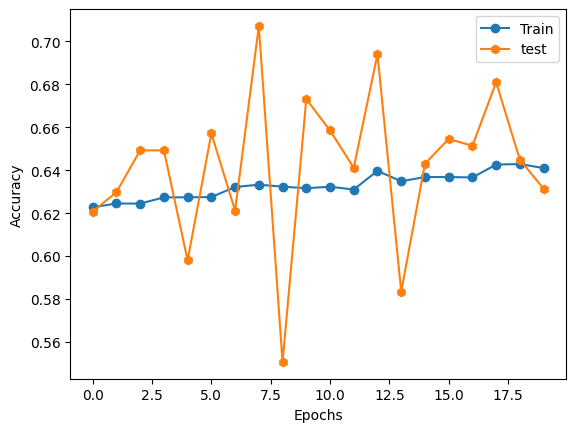

In [43]:
line1 = plt.plot(vgg16_model2.history.history["accuracy"], marker="o")
line2 = plt.plot(vgg16_model2.history.history["val_accuracy"], marker="h")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "test"])
plt.show()

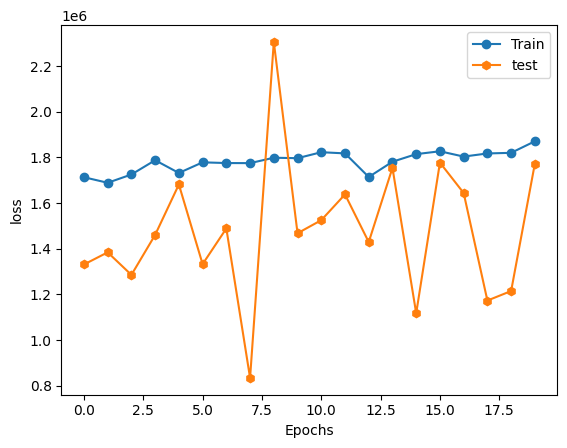

In [44]:
line1 = plt.plot(vgg16_model2.history.history["loss"], marker="o")
line2 = plt.plot(vgg16_model2.history.history["val_loss"], marker="h")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["Train", "test"])
plt.show()